In [146]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces 
import warnings
warnings.filterwarnings("ignore") # type: ignore

# Environment Setup

In [147]:
class UAV_env(gym.Env):
    def __init__(self):
        # UAV parameters
        self.m = 1.56  # Mass (kg)
        self.Jyy = 0.0576  # Moment of inertia (kg-m^2)
        self.CL = lambda a: (3.5*a) + 0.09  # Lift coefficient
        self.CD = lambda a: (0.2*a) + 0.016  # Drag coefficient
        self.CLdelta = 0.27  # Lift coefficient derivative
        self.Cm0 = -0.02  # Pitching moment coefficient at zero angle of attack
        self.Cmalpha = -0.57  # Pitching moment coefficient derivative
        self.Cmq = -1.4  # Pitching moment coefficient derivative
        self.Cmdelta = -0.32  # Pitching moment coefficient derivative

        # Initial state
        self.X0 = np.array([9.96, 0.87, 0, 0.0873, 50])  # [u, w, q, theta, h]
        self.U0 = np.array([1.0545, -0.2179])  # [T, delta]

        # Desired final state
        self.Xd = np.array([9.85, 1.74, 0, 0.1745, 62])

        # State and control constraints
        self.T_min = 0
        self.T_max = 4
        self.delta_min = -0.4363
        self.delta_max = 0.1745
        self.Va_min = 5
        self.Va_max = 15
        self.alpha_min = 0
        self.alpha_max = 0.2618

        # Simulation time
        self.dt = 0.02  # Sampling time (seconds)
        self.t_final = 10  # Final time (seconds)
        self.t = 0

        # Define action and observation spaces
        self.action_space = spaces.Box(low=np.array([self.T_min, self.delta_min]), high=np.array([self.T_max, self.delta_max]), dtype=np.float32) # Continuous action space
        
        # self.action_space = spaces.MultiDiscrete([2, 2]) # Discrete action space
        # self.action_space.n = 4
        # self.transform = lambda a: np.array([self.T_max-self.T_min, self.delta_max-self.delta_min])*a + np.array([self.T_min, self.delta_min])
        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)

        self.state = None

    def dynamics(self, X, U):
        u, w, q, theta, h = X       # States
        T, delta = U                # Controls
        # T, delta = self.transform(U) # Transform discrete action 

        Va = np.sqrt(u**2 + w**2)   # Airspeed (need to check this to keep within constraints)
        alpha = np.arctan(w / u)    # Angle of attack (need to check this to keep within constraints)

        CL = self.CL(alpha)         # Lift coefficient
        CD = self.CD(alpha)         # Drag coefficient

        udot = (-q*w) + (0.5*Va**2/self.m) * (CL*np.sin(alpha) - CD*np.cos(alpha) + self.CLdelta*np.sin(alpha)*delta) - (9.81*np.sin(theta)) + (T/self.m)
        wdot = (q*u) + (0.5*Va**2/self.m) * (-CL*np.cos(alpha) - CD*np.sin(alpha) - self.CLdelta*np.cos(alpha)*delta) + (9.81*np.cos(theta))
        qdot = (0.5*Va**2/self.Jyy) * (self.Cm0 + self.Cmalpha*alpha + (0.25*self.Cmq*q/Va) + self.Cmdelta*delta)
        thetadot = q
        hdot = (-u*np.sin(theta)) + (w*np.cos(theta))

        return np.array([udot, wdot, qdot, thetadot, hdot]) # Return state derivatives

    def step(self, action):
        # action = np.clip(action, self.action_space.low, self.action_space.high)
        self.state = self.integrate(self.state, action) 
        u, w, _, _, _ = self.state
        Va = np.sqrt(u**2 + w**2)
        alpha = np.arctan(w / u)
        if Va < self.Va_min or Va > self.Va_max or alpha < self.alpha_min or alpha > self.alpha_max:
            reward = -np.inf  # Penalize out of bounds states
            done = True
        reward = -np.sum(np.abs(self.state - self.Xd)) # Negative sum of absolute state errors
        done = False
        if self.t >= 10:
            done = True
        info = {} # store additional metadata for debugging 
        return self.state, reward, done, info

    def reset(self):
        self.state = np.copy(self.X0)
        self.t = 0
        return self.state

    def integrate(self, X, U):
        X_dot = self.dynamics(X, U)
        X += self.dt * X_dot
        self.t += self.dt
        return X

    def render(self, mode='human'):
        # print(self.state)  
        pass

# Environment Test (Random Action)

Episode:1 Score:-9254.639111975139


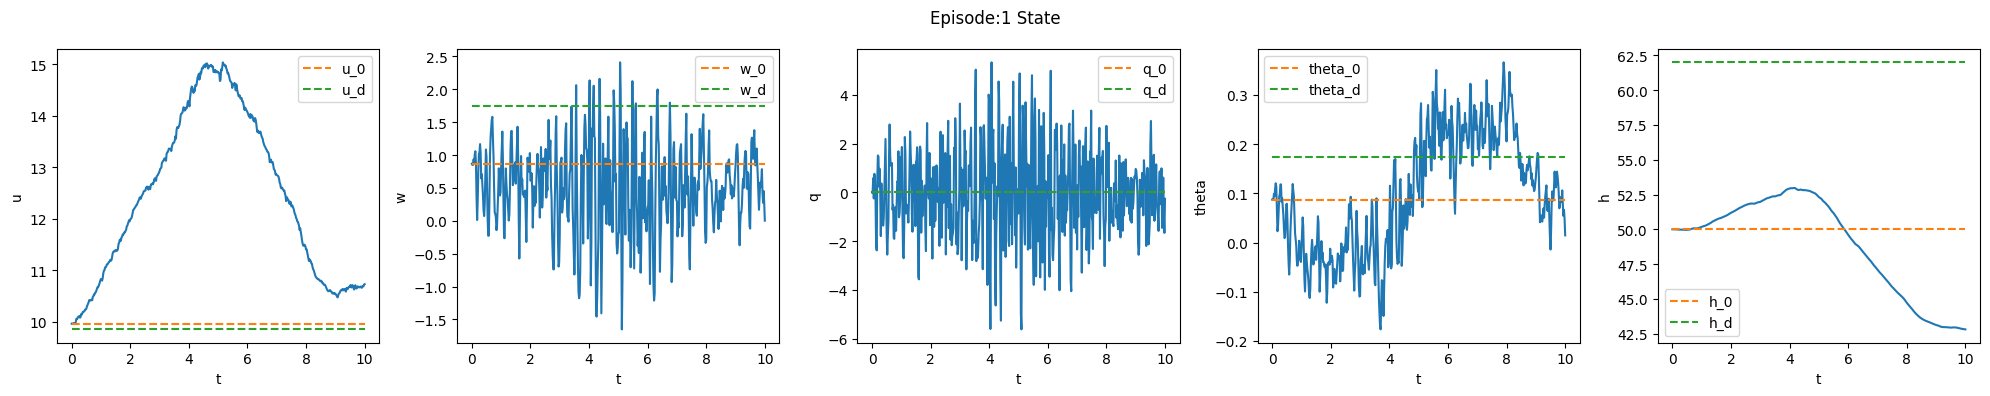

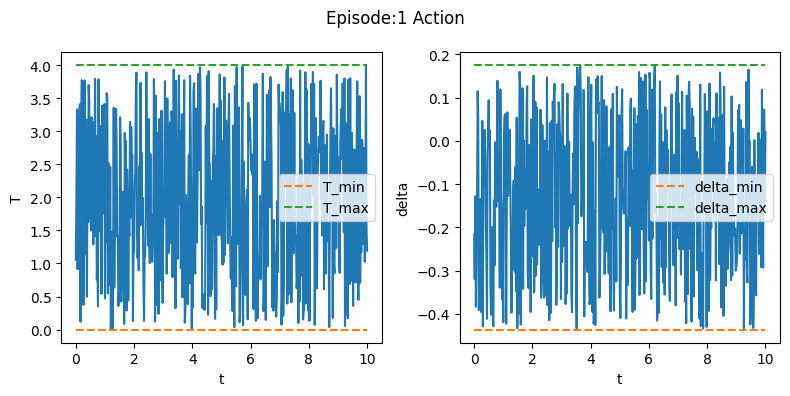

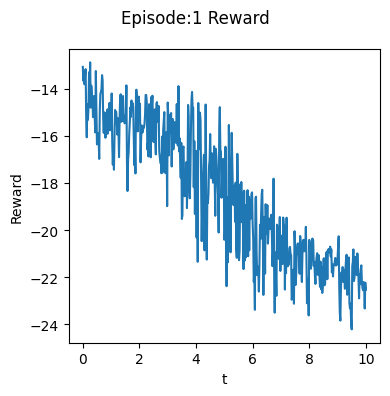

Episode:2 Score:-9728.45329358169


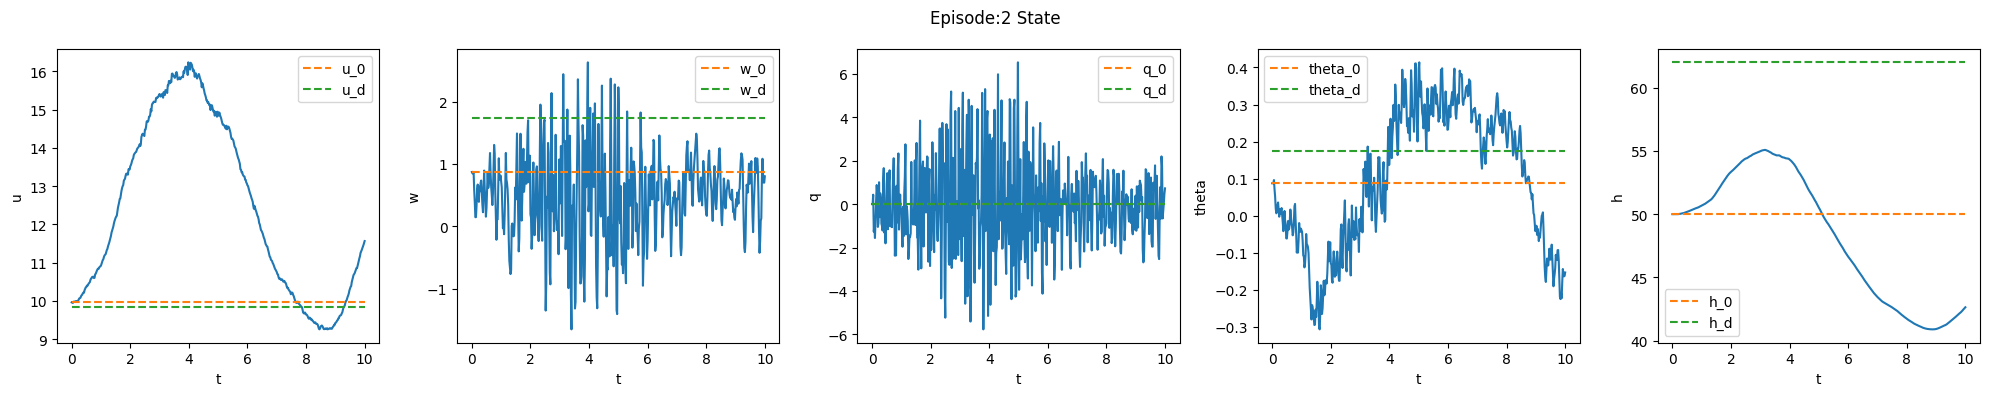

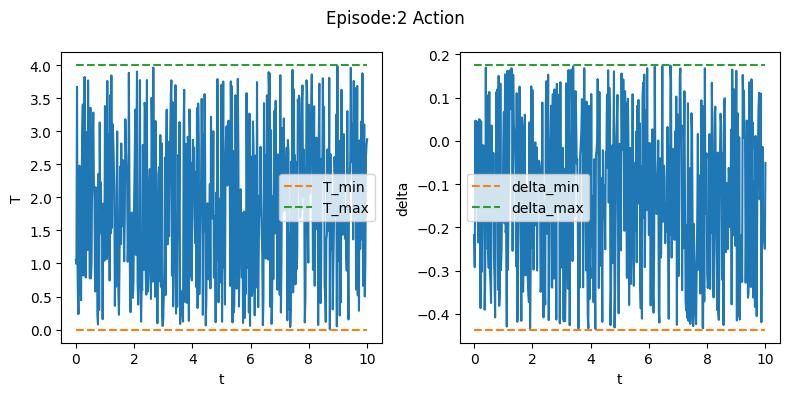

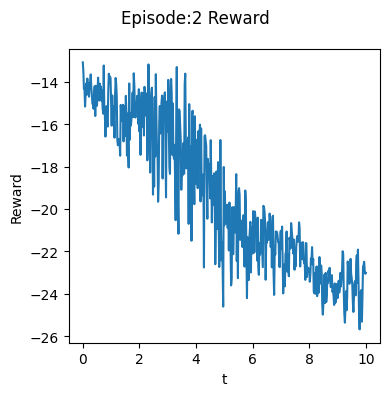

Episode:3 Score:nan


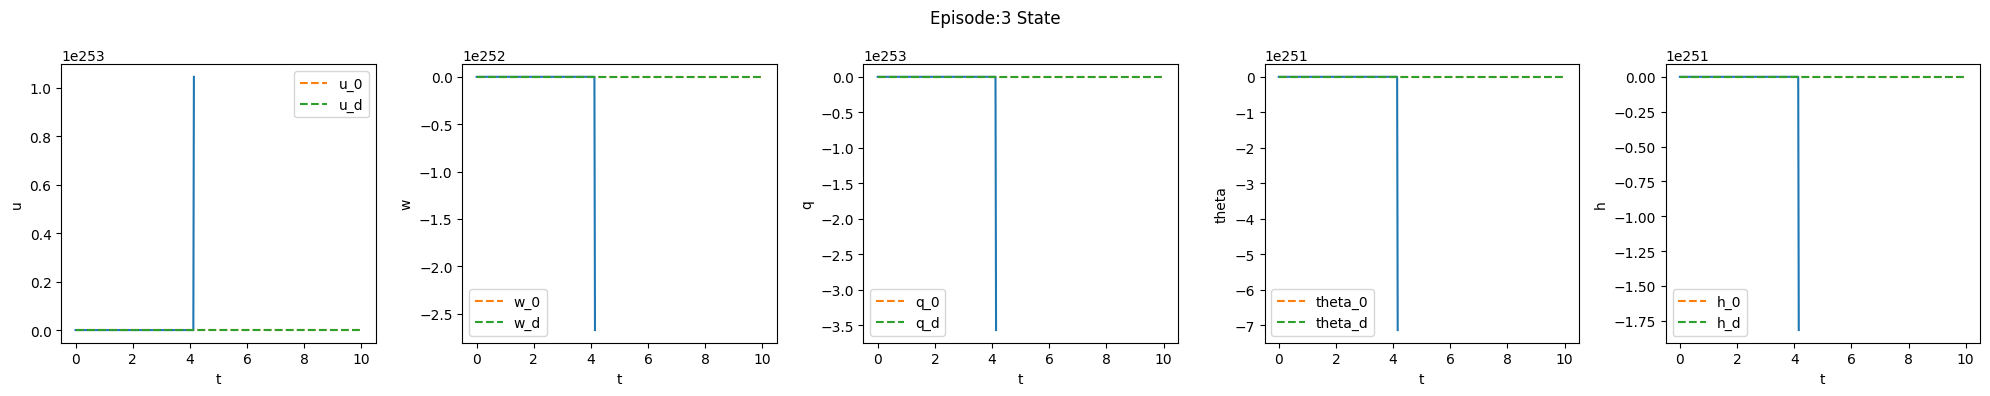

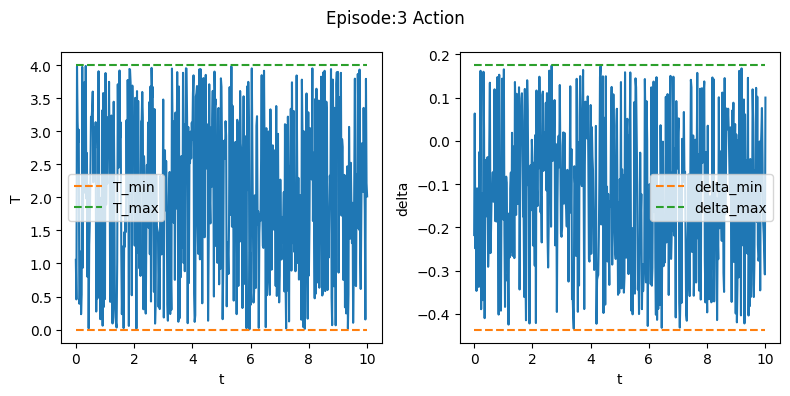

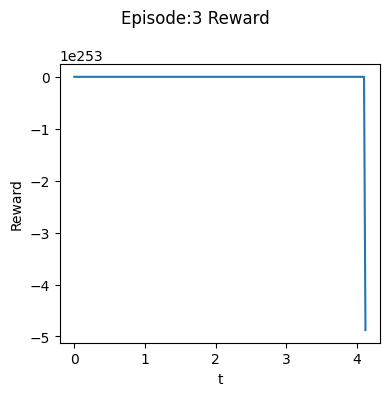

Episode:4 Score:nan


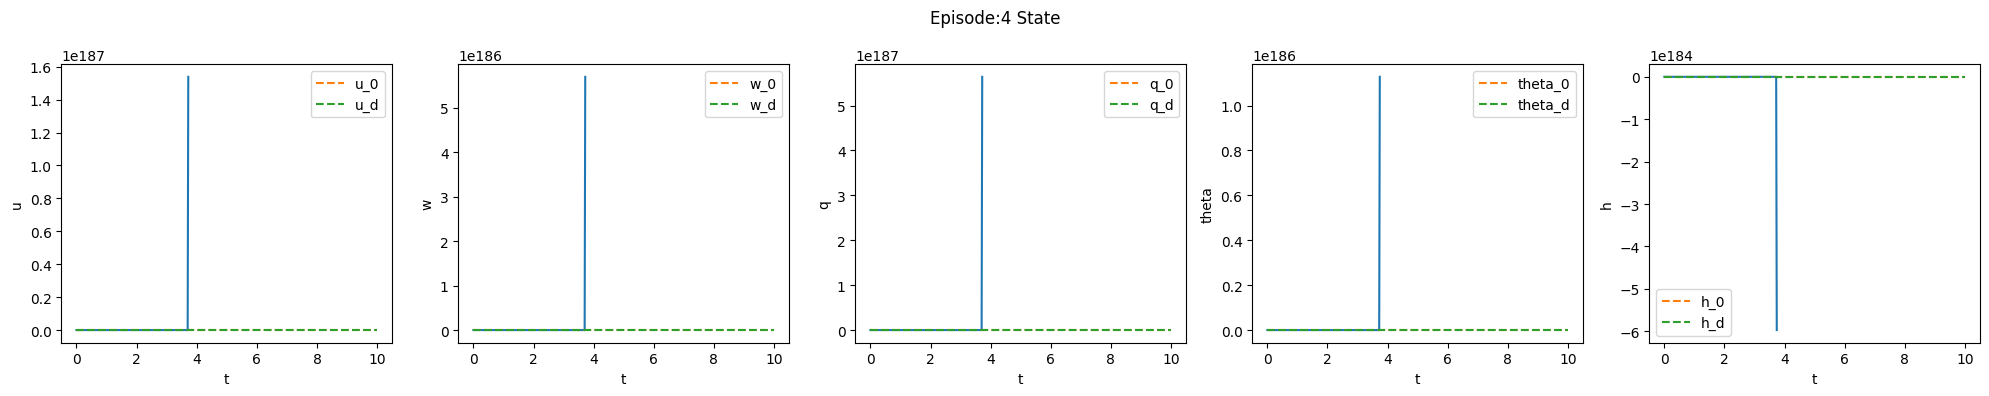

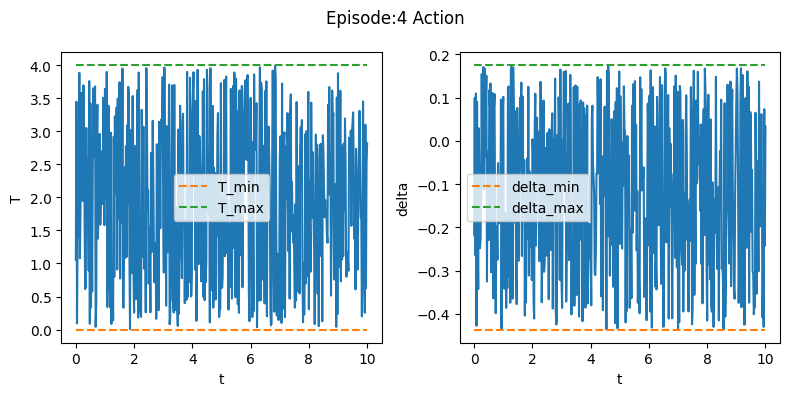

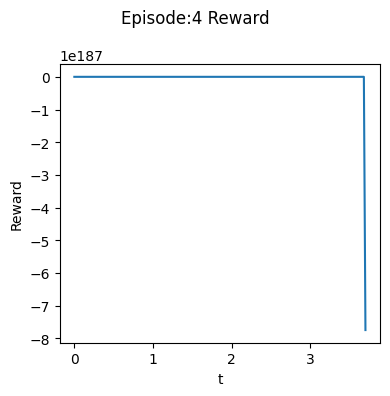

Episode:5 Score:-8871.731848760583


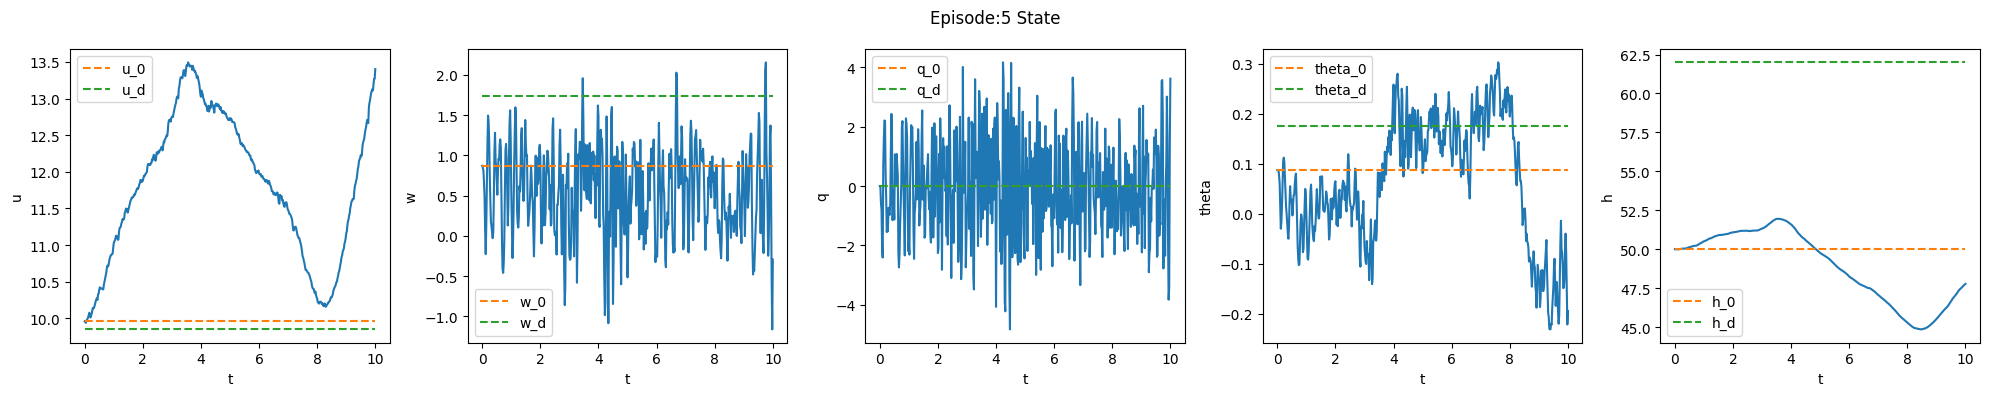

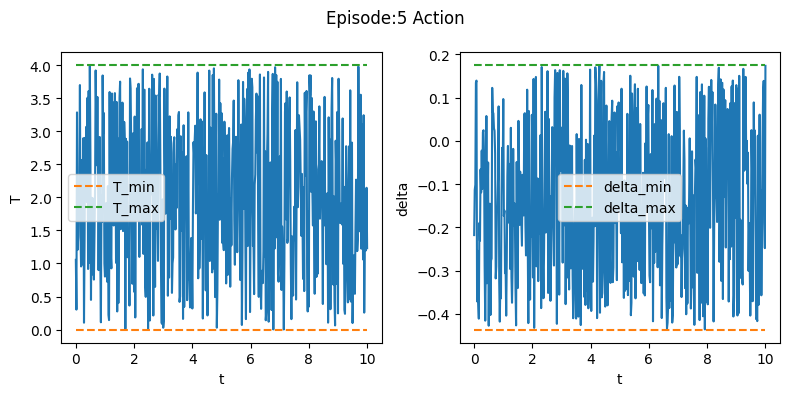

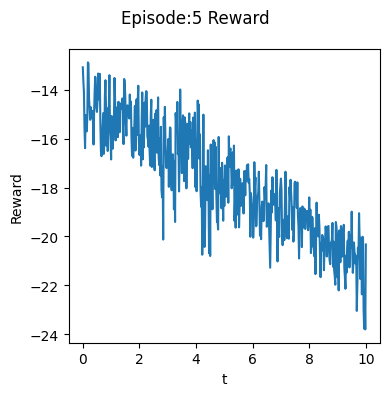

Episode:6 Score:-9405.963277222327


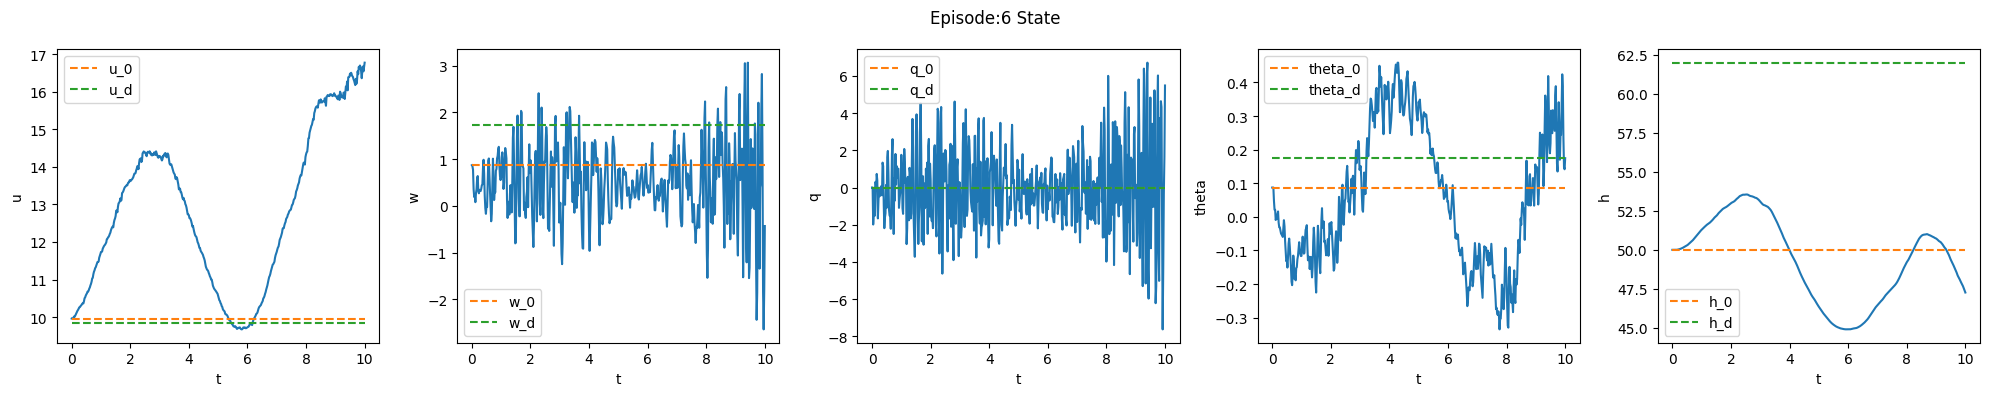

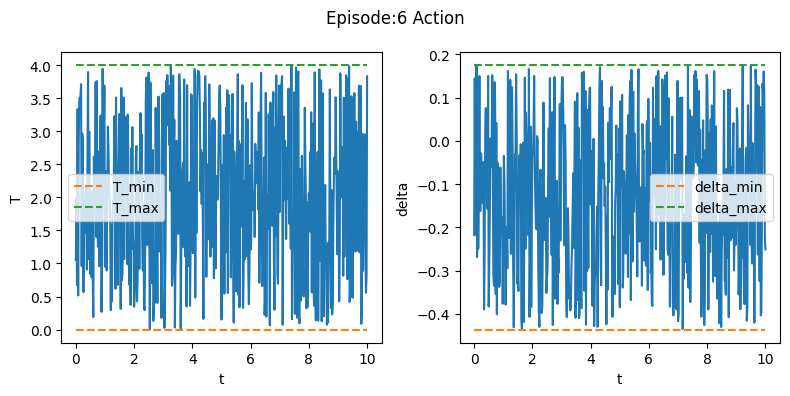

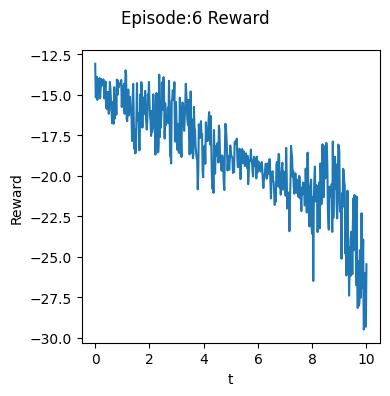

Episode:7 Score:-9090.18356594398


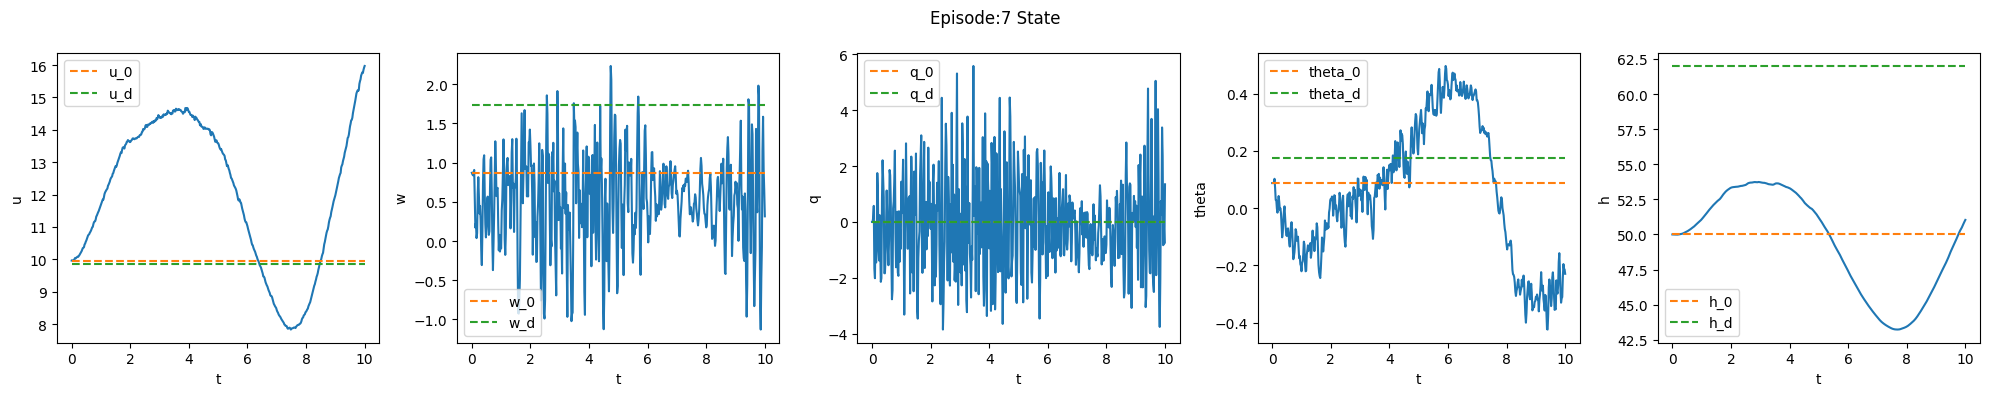

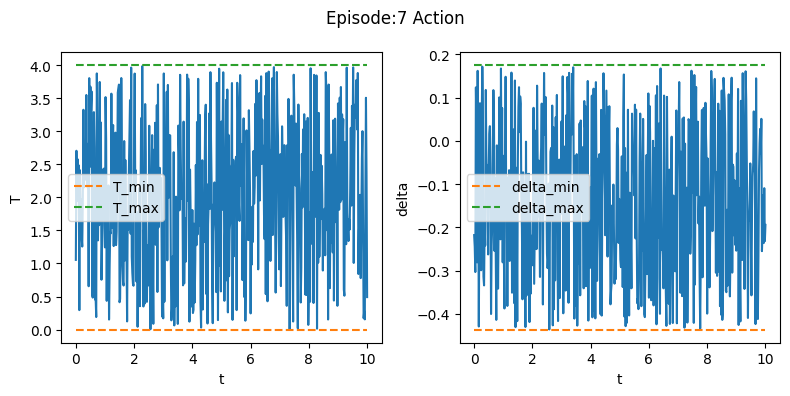

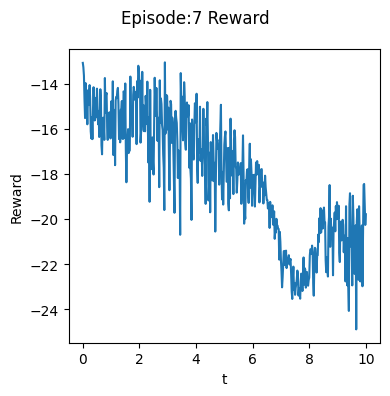

Episode:8 Score:-9363.498285499767


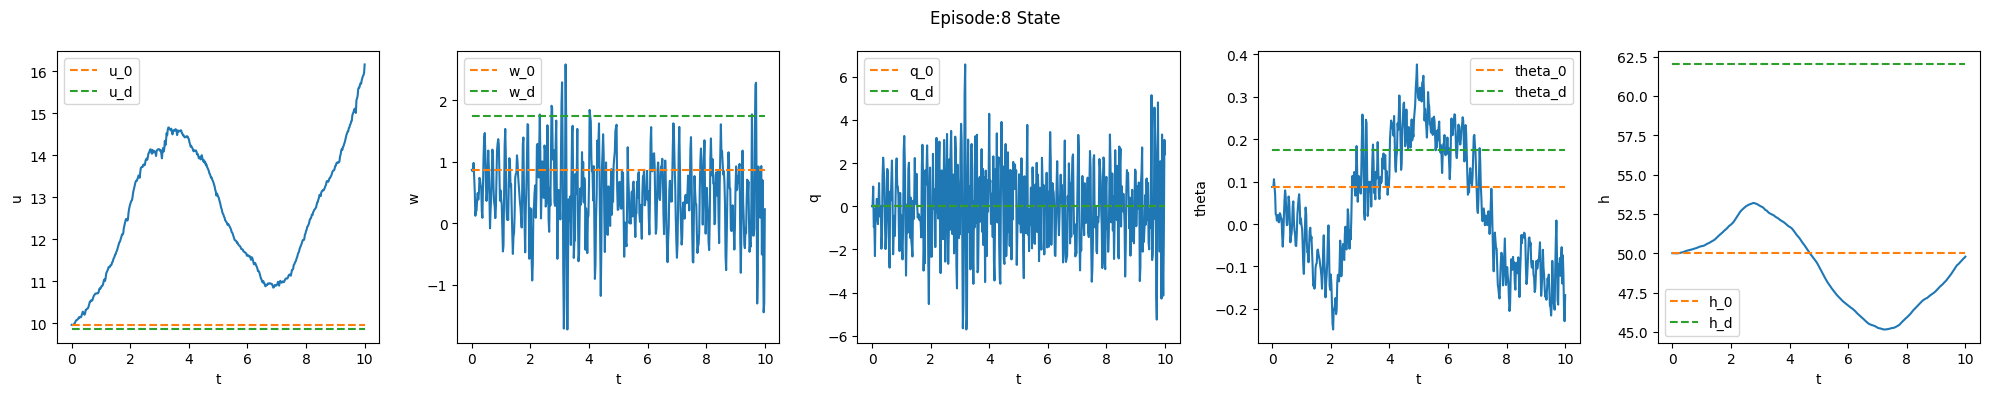

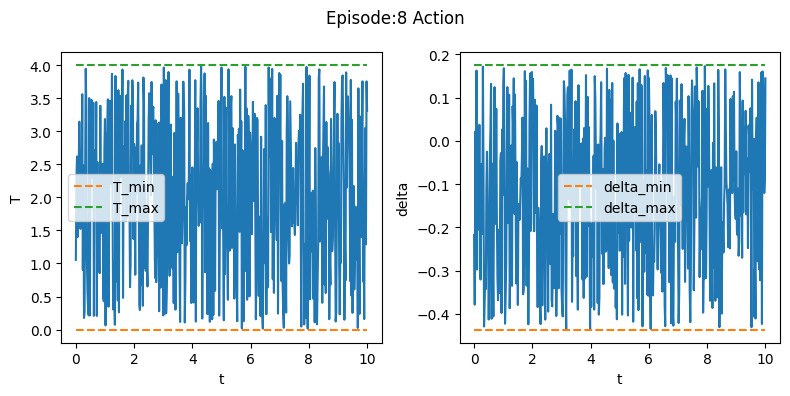

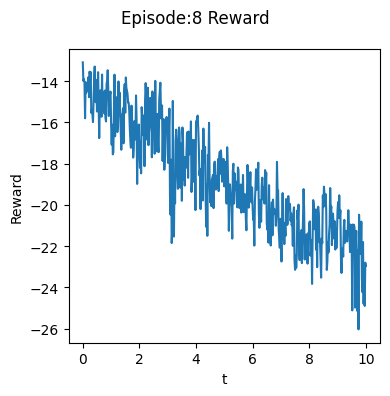

Episode:9 Score:-10255.990915054677


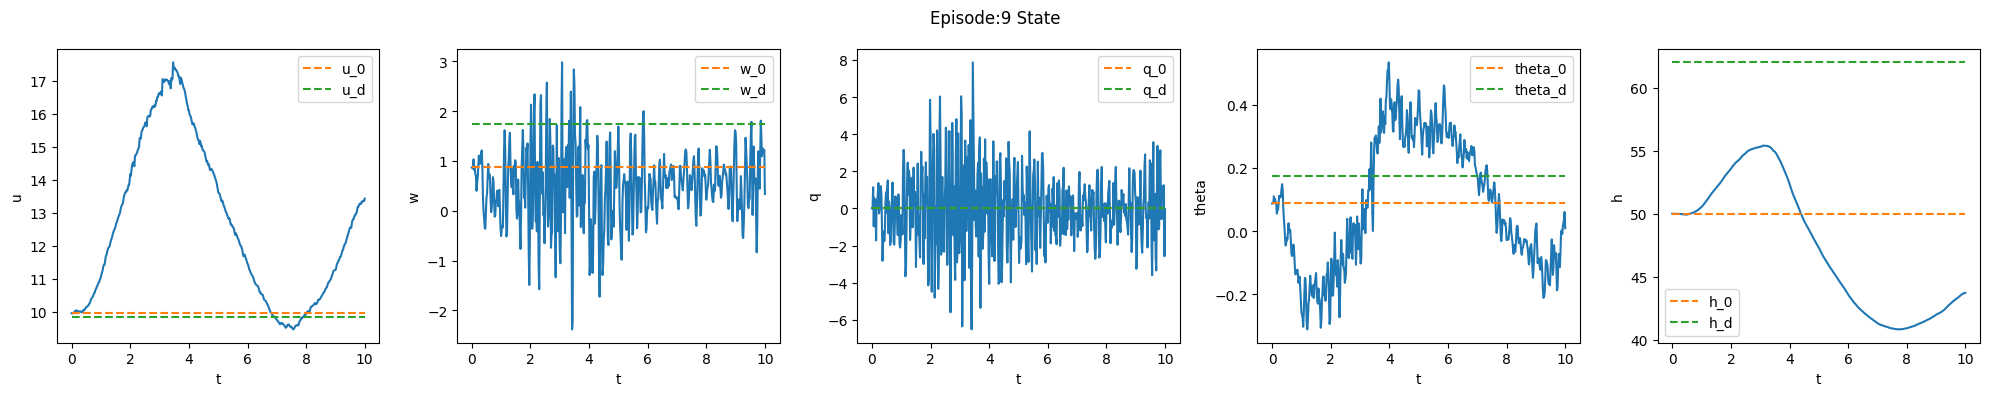

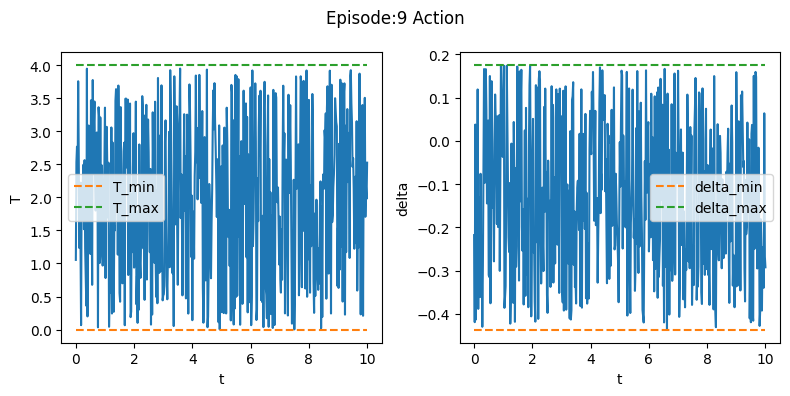

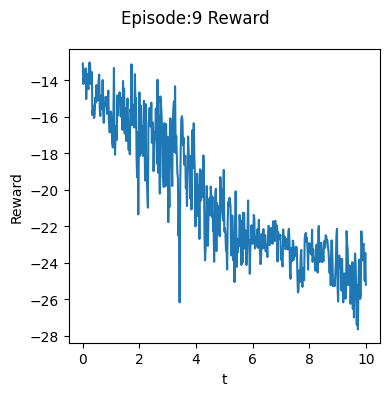

Episode:10 Score:nan


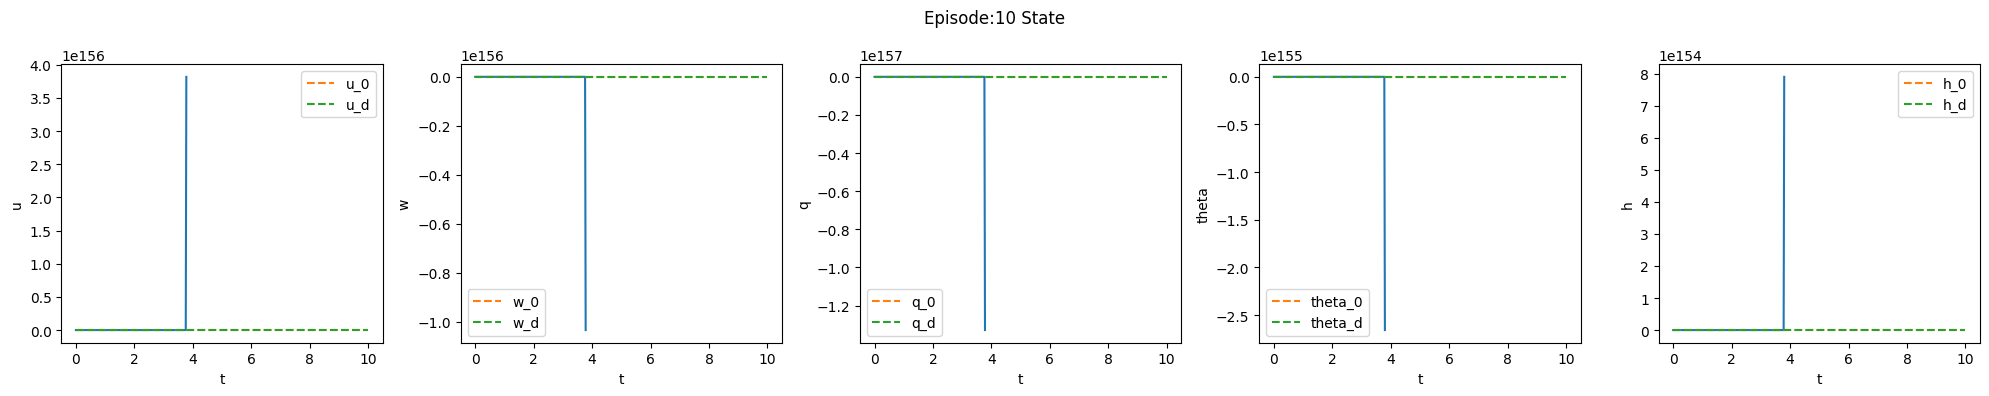

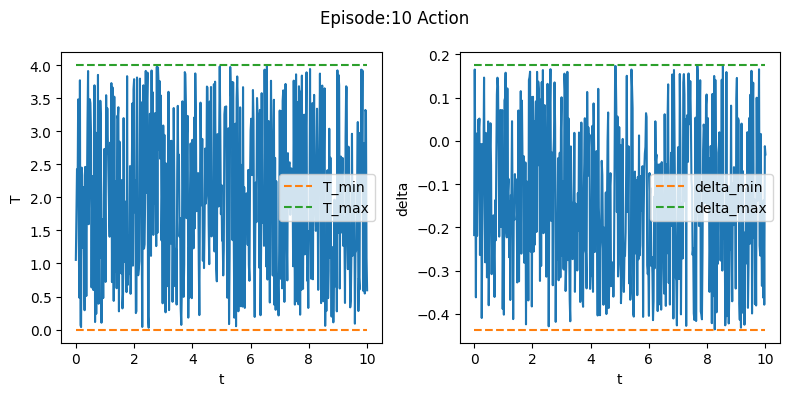

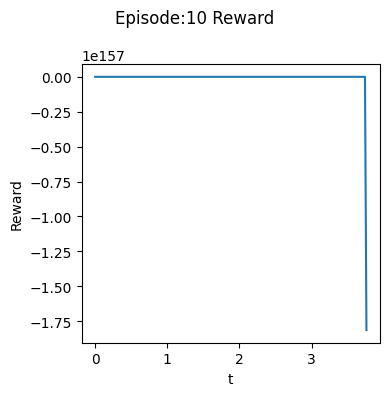

In [148]:
env = UAV_env()
num_episodes = 10
for episode in range(num_episodes):
    state = env.reset()
    done = False
    score = 0
    Xd = env.Xd
    X0 = env.X0
    X = []  
    t = []
    U = []
    R = []
    while not done:
        if env.t == 0:
            action = env.U0
        else:
            # action = DQN(state)  # Use DQN in keras-rl2 to get our actual action policy
            action = env.action_space.sample() # Random action to test environment
        U.append([action[0], action[1]])
        t.append(env.t)
        X.append([state[0], state[1], state[2], state[3], state[4]])
        state, reward, done, info = env.step(action)
        score += reward
        R.append(reward)
    print('Episode:{} Score:{}'.format(episode+1, score))
    u, w, q, theta, h = np.array(X).T
    t = np.array(t)
    R = np.array(R)
    T, delta = np.array(U).T
    u0, w0, q0, theta0, h0 = X0
    ud, wd, qd, thetad, hd = Xd
    Tmin, Tmax = env.T_min, env.T_max
    deltamin, deltamax = env.delta_min, env.delta_max
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, u)
    plt.plot(t, u0*np.ones_like(t), '--', label='u_0')
    plt.plot(t, ud*np.ones_like(t), '--', label='u_d')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.legend()
    plt.suptitle('Episode:{} State'.format(episode+1))
    plt.subplot(1, 5, 2)
    plt.plot(t, w)
    plt.plot(t, w0*np.ones_like(t), '--', label='w_0')
    plt.plot(t, wd*np.ones_like(t), '--', label='w_d')
    plt.xlabel('t')
    plt.ylabel('w')
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.plot(t, q)
    plt.plot(t, q0*np.ones_like(t), '--', label='q_0')
    plt.plot(t, qd*np.ones_like(t), '--', label='q_d')
    plt.xlabel('t')
    plt.ylabel('q')
    plt.legend()
    plt.subplot(1, 5, 4)
    plt.plot(t, theta)
    plt.plot(t, theta0*np.ones_like(t), '--', label='theta_0')
    plt.plot(t, thetad*np.ones_like(t), '--', label='theta_d')
    plt.xlabel('t')
    plt.ylabel('theta')
    plt.legend()
    plt.subplot(1, 5, 5)
    plt.plot(t, h)
    plt.plot(t, h0*np.ones_like(t), '--', label='h_0')
    plt.plot(t, hd*np.ones_like(t), '--', label='h_d')
    plt.xlabel('t')
    plt.ylabel('h')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t, T)
    plt.plot(t, Tmin*np.ones_like(t), '--', label='T_min')
    plt.plot(t, Tmax*np.ones_like(t), '--', label='T_max')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('T')
    plt.subplot(1, 2, 2)
    plt.plot(t, delta)
    plt.plot(t, deltamin*np.ones_like(t), '--', label='delta_min')
    plt.plot(t, deltamax*np.ones_like(t), '--', label='delta_max')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('delta')
    plt.suptitle('Episode:{} Action'.format(episode+1))
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(4, 4))
    plt.plot(t, R)
    plt.xlabel('t')
    plt.ylabel('Reward')
    plt.suptitle('Episode:{} Reward'.format(episode+1))
    plt.tight_layout()
    plt.show()
env.close()

In [149]:
import torch
import torch.nn as nn
import torchrl as trl

# DQN Setup

In [150]:
class DQNModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gym.register("UAV-v0", env)
env = trl.envs.GymEnv("UAV-v0", device=device)

# Initialize the DQN model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
model = DQNModel(state_dim, action_dim).to(device)

# Define the DQN agent
dqn = trl.agents.DQN(model, env.action_space, device=device)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

AttributeError: 'UAV_env' object has no attribute 'split'

# DQN Test

In [152]:
# Training loop
num_episodes = 10
for episode in range(num_episodes):
    state = env.reset()
    done = False
    score = 0
    Xd = env.Xd
    X0 = env.X0
    X = []  
    t = []
    U = []
    R = []
    while not done:
        if env.t == 0:
            action = env.U0
        else:
            action = dqn.act(state)
        U.append([action[0], action[1]])
        t.append(env.t)
        X.append([state[0], state[1], state[2], state[3], state[4]])
        next_state, reward, done, _ = env.step(action)
        score += reward
        R.append(reward)
        dqn.store(state, action, reward, next_state, done)
        state = next_state

        if dqn.should_update():
            loss = dqn.update(optimizer, loss_fn)
            # Print or log the loss if needed

    print(f"Episode {episode}: Score = {score}")
    u, w, q, theta, h = np.array(X).T
    t = np.array(t)
    R = np.array(R)
    T, delta = np.array(U).T
    u0, w0, q0, theta0, h0 = X0
    ud, wd, qd, thetad, hd = Xd
    Tmin, Tmax = env.T_min, env.T_max
    deltamin, deltamax = env.delta_min, env.delta_max
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 5, 1)
    plt.plot(t, u)
    plt.plot(t, u0*np.ones_like(t), '--', label='u_0')
    plt.plot(t, ud*np.ones_like(t), '--', label='u_d')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.legend()
    plt.suptitle('Episode:{} State'.format(episode+1))
    plt.subplot(1, 5, 2)
    plt.plot(t, w)
    plt.plot(t, w0*np.ones_like(t), '--', label='w_0')
    plt.plot(t, wd*np.ones_like(t), '--', label='w_d')
    plt.xlabel('t')
    plt.ylabel('w')
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.plot(t, q)
    plt.plot(t, q0*np.ones_like(t), '--', label='q_0')
    plt.plot(t, qd*np.ones_like(t), '--', label='q_d')
    plt.xlabel('t')
    plt.ylabel('q')
    plt.legend()
    plt.subplot(1, 5, 4)
    plt.plot(t, theta)
    plt.plot(t, theta0*np.ones_like(t), '--', label='theta_0')
    plt.plot(t, thetad*np.ones_like(t), '--', label='theta_d')
    plt.xlabel('t')
    plt.ylabel('theta')
    plt.legend()
    plt.subplot(1, 5, 5)
    plt.plot(t, h)
    plt.plot(t, h0*np.ones_like(t), '--', label='h_0')
    plt.plot(t, hd*np.ones_like(t), '--', label='h_d')
    plt.xlabel('t')
    plt.ylabel('h')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t, T)
    plt.plot(t, Tmin*np.ones_like(t), '--', label='T_min')
    plt.plot(t, Tmax*np.ones_like(t), '--', label='T_max')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('T')
    plt.subplot(1, 2, 2)
    plt.plot(t, delta)
    plt.plot(t, deltamin*np.ones_like(t), '--', label='delta_min')
    plt.plot(t, deltamax*np.ones_like(t), '--', label='delta_max')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('delta')
    plt.suptitle('Episode:{} Action'.format(episode+1))
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(4, 4))
    plt.plot(t, R)
    plt.xlabel('t')
    plt.ylabel('Reward')
    plt.suptitle('Episode:{} Reward'.format(episode+1))
    plt.tight_layout()
    plt.show()
env.close()

NameError: name 'dqn' is not defined